In [81]:
import numpy as np
import pandas as pd
from dateutil.parser import parse
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.patches as mpatches

import nltk
from nltk.corpus import stopwords
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import math


In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
candle_df = pd.read_csv('/content/drive/My Drive/MODS208/Datasets/US_Scented_Candles.csv')
covid_df = pd.read_csv('/content/drive/My Drive/MODS208/Datasets/US_Covid_Cases.csv')
uncandle_df = pd.read_csv('/content/drive/My Drive/MODS208/Datasets/US_Unscented_Candles.csv')

In [84]:
candle_df.loc[:, 'date'] = pd.to_datetime(candle_df.date)
covid_df.loc[:, 'date'] = pd.to_datetime(covid_df.date)
uncandle_df.loc[:, 'date'] = pd.to_datetime(uncandle_df.date)
uncandle_df = uncandle_df[uncandle_df.date<=max(candle_df.date)]

### Data analysis

In [86]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
a = candle_df.describe()
a= a.rename(columns = {'rating': 'scented_rating'})
a.loc[:, 'unscented_rating'] = uncandle_df.describe()
a.loc[:, ['daily_new_cases', 'active_cases']] = covid_df.describe()
a

,scented_rating,helpful,unscented_rating,daily_new_cases,active_cases
count,30748.00,30748.00,9040.00,443.00,443.00
mean,4.05,0.67,4.39,75437.50,3721175.15
std,1.48,14.39,1.23,65283.96,2938434.23
min,1.00,0.00,1.00,0.00,10.00
25%,3.00,0.00,5.00,32012.50,1110581.00
50%,5.00,0.00,5.00,55082.00,2419304.00
75%,5.00,0.00,5.00,81844.00,6692772.50
max,5.00,1576.00,5.00,303926.00,9027330.00


### Graphs

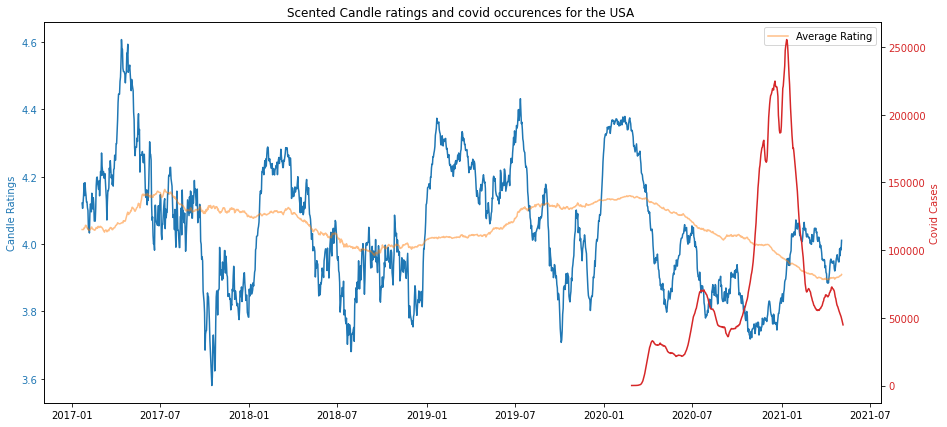

In [88]:
#df.groupby('date').mean()['rating']
days = candle_df.groupby('date').mean()['rating']
fig, ax1 = plt.subplots(figsize=(15,7))

covid_days = covid_df.groupby('date').mean()['daily_new_cases']

plt.title('Scented Candle ratings and covid occurences for the USA ')
color = 'tab:blue'
covid_candle_df = candle_df[candle_df.date>='2016']
days = covid_candle_df.groupby('date').mean()['rating']
ax1.plot(days.index[365:], days.rolling(30).mean()[365:], color=color)
ax1.plot(days.index[365:], days.rolling(365).mean()[365:], label='Average Rating', color='C1', alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('Candle Ratings', color=color)
ax1.legend()

ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(covid_df.date[7:], covid_df['daily_new_cases'].rolling(7).mean()[7:],
         color=color, label='Covid cases')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Covid Cases', color=color)


plt.show()

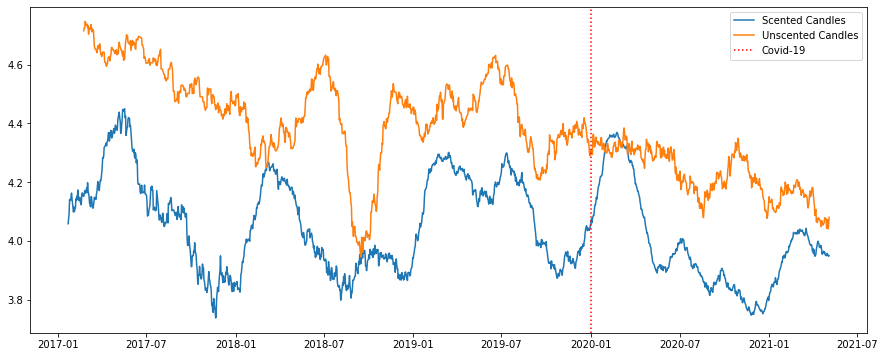

In [89]:
plt.figure(figsize=(15,6))
days = covid_candle_df.groupby('date').mean()['rating']
plt.plot(days.index[365:], days.rolling(60).mean()[365:], label='Scented Candles')
uncovid_candle_df = uncandle_df[uncandle_df.date>='2016']
undays = uncovid_candle_df.groupby('date').mean()['rating']
plt.plot(undays.index[365:], undays.rolling(60).mean()[365:], label='Unscented Candles')

from datetime import datetime

datetime_object = datetime.strptime('2020', '%Y')
plt.axvline(datetime_object, color='red', ls=':', label='Covid-19')
plt.legend()
plt.show()

In [90]:
candle_df=candle_df.drop(['helpful'], axis=1)
covid_df=covid_df.drop(['daily_new_deaths'], axis=1)

In [91]:
max(covid_df['date'])

Timestamp('2021-05-07 00:00:00')

## Difference in difference

In [92]:
candle_dif = candle_df.copy()
candle_dif.loc[:, 'id'] = candle_df.Model+candle_df.Brand

In [93]:
dif_can = candle_dif.drop(['title', 'text', 'Brand', 'Model'], axis=1)
undif_can = uncandle_df.drop(['text', 'title'], axis=1)

In [94]:
dif_can.loc[dif_can.date<'2020', 'covid']=0
dif_can.loc[dif_can.date>='2020', 'covid']=1
undif_can.loc[undif_can.date<'2020', 'covid']=0
undif_can.loc[undif_can.date>='2020', 'covid']=1

dif_can.loc[:, 'scented']=1
undif_can.loc[:, 'scented']=0

dif_can.loc[:, 'scentedXcovid'] = dif_can.loc[:, 'scented']*dif_can.loc[:, 'covid']
undif_can.loc[:, 'scentedXcovid'] = undif_can.loc[:, 'scented']*undif_can.loc[:, 'covid']



dif_can= pd.get_dummies(dif_can, columns=['id'], drop_first=True)
undif_can= pd.get_dummies(undif_can, columns=['id'], drop_first=True)


#undif_can.loc[:, 'id']=0

In [95]:
#dif = pd.concat([dif_can, undif_can])
dif = dif_can.merge(undif_can, how = 'outer')
dif = dif.fillna(0)
dif.loc[:, 'month']=dif.date.dt.month_name()
dif = pd.get_dummies(dif, columns=['month'], drop_first=True)

for i in dif.date.unique():
  dif.loc[dif.date==i, 'purchases'] = np.shape(dif[dif.date==i])[0]
aux = dif.pop('purchases')
dif.insert(3, 'purchases', aux)

In [96]:
X = dif.drop(['rating', 'date'], axis=1)
X.loc[:, 'scentedXcovid'] = X.loc[:, 'scented']*X.loc[:, 'covid']
X = sm.add_constant(X)
y = dif.rating

model = sm.RLM(y, X)
results = model.fit()
print(results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                 rating   No. Observations:                39788
Model:                            RLM   Df Residuals:                    39748
Method:                          IRLS   Df Model:                           39
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 14 Jun 2021                                         
Time:                        16:45:10                                         
No. Iterations:                    50                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.55

## Joining both datasets

In [97]:
candle_df.loc[:, 'id'] = candle_df.Model+candle_df.Brand
df = candle_df.drop(['Brand', 'Model'], axis=1)
df.loc[:, 'scented']=1
uncandle_df.loc[:, 'scented'] =0 
df= pd.get_dummies(df, columns=['id'], drop_first=True)
uncandle_df= pd.get_dummies(uncandle_df, columns=['id'], drop_first=True)
df = df.merge(uncandle_df, how = 'outer')
df = covid_df.merge(df, on='date', how='right')
df = df.fillna(0)
#df.head()

## Monthly variables

In [98]:
df.loc[:, 'month']=df.date.dt.month_name()

In [99]:
def plot_monthly_bar(df, start_date, end_date, mid_date):
    df_start = df.loc[(df.date>start_date)&(df.date<mid_date)]
    df_end = df[(df.date>mid_date)&(df.date<end_date)]
    df_start = df_start.groupby('month').mean()['rating']
    df_end = df_end.groupby('month').mean()['rating']
    
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']
    x = np.arange(len(months))
    
    fig, ax = plt.subplots(figsize=(15,6))
    w=0.4
    ax.bar(x-w/2, df_start[months], label='Pre covid', align='center', width=w)
    ax.bar(x+w/2, df_end[months], label='During covid', align='center', width=w)
    plt.title(f'Monthly Averages for ratings')
    ax.set_xticks(x)
    ax.set_xticklabels(months)
    plt.legend()

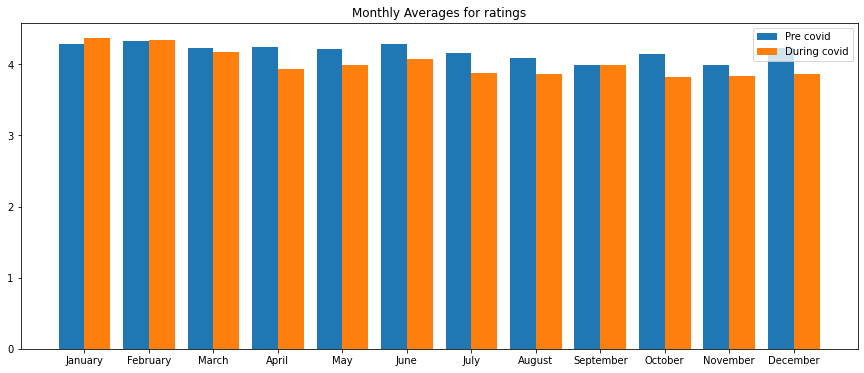

In [100]:
plot_monthly_bar(df, '2018', '2021', '2020')

## Seasonal variables

In [101]:
df.loc[df.month.isin(['June', 'July', 'August']), 'season']='Summer'
df.loc[df.month.isin(['March', 'April', 'May']), 'season']='Spring'
df.loc[df.month.isin(['September', 'October', 'November']), 'season']='Fall'
df.loc[df.month.isin(['December', 'January', 'February']), 'season']='Winter'

## Prepping for regression

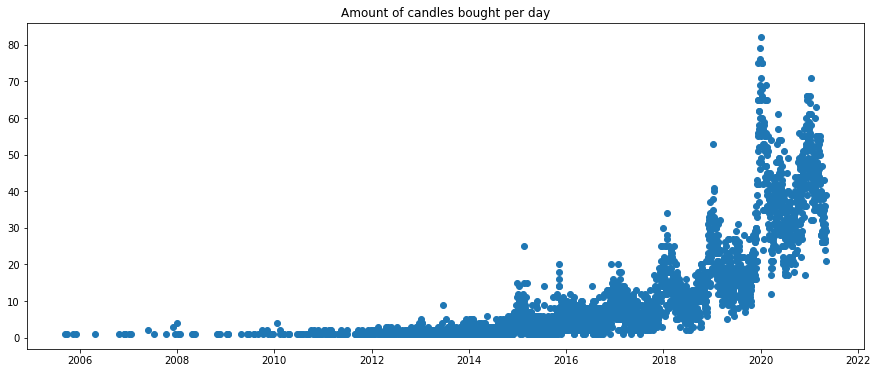

In [102]:
dates = df.date.unique()
aux = []
for i in dates:
  aux.append(np.shape(df[df.date==i])[0])

plt.figure(figsize=(15,6))
plt.title('Amount of candles bought per day')
plt.scatter(dates, aux)
plt.show()

In [103]:
def regression (df, covid_df, dummy='month', covid='active', only_covid=False,
                shift=0, dates=True):
    df = df.drop(['text', 'title'], axis=1)
    if dummy=='season':
        df = pd.get_dummies(df, columns=['season'], drop_first=True)
        df = df.drop(['month'], axis=1)
    if dummy=='month':
        df = pd.get_dummies(df, columns=['month'], drop_first=True)
        df = df.drop(['season'], axis=1)
    if covid=='active':
        df = df.drop(['daily_new_cases'], axis=1)
        covid_df = covid_df.drop(['daily_new_cases'], axis=1)
        df.loc[:, 'active_cases'] = np.log(1+df.active_cases)
        covid_df.loc[:, 'active_cases'] = np.log(1+covid_df.active_cases)
        aux=new_name='active_cases'
    if covid=='new':
        df = df.drop(['active_cases'], axis=1)
        covid_df = covid_df.drop(['active_cases'], axis=1)
        df.loc[:, 'daily_new_cases'] = np.log(1+df.daily_new_cases)
        covid_df.loc[:, 'daily_new_cases'] = np.log(1+covid_df.daily_new_cases)
        aux=new_name='daily_new_cases'
    if only_covid==True:
        df = df[df.date>'2020']
    else:
      df['year'] = df['date'].dt.year
      df = pd.get_dummies(df, columns=['year'], drop_first=True)
      df = df.drop(['year_2021'], axis=1)
    if shift != 0:
        new_name = f'{covid_df.columns[1]}_{shift}'
        covid_df= covid_df.rename(columns = {covid_df.columns[1]:f'{covid_df.columns[1]}_{shift}'})
        covid_df.loc[:, 'date'] = covid_df.date + pd.DateOffset(days=shift)
        df = df.merge(covid_df, on='date', how='left')
        df = df.fillna(0)
        df = df[df.date<max(df.date)-pd.DateOffset(days=shift)]
        df = df.drop([aux], axis=1)
        aux = df.pop(new_name)
        df.insert(3, new_name, aux)
    if dates == True:
      dates = df.date.unique()
      for i in dates:
        df.loc[df.date==i, 'purchases'] = np.shape(df[df.date==i])[0]
      aux = df.pop('purchases')
      df.insert(3, 'purchases', aux)

    
    #df = df.groupby('date').mean().reset_index()
    #df.loc[:, 'covidXscented'] = df[new_name]*df.scented
    df.insert(2, f'{new_name}Xscented', df[new_name]*df.scented)
    X = df.drop(['rating', 'date'], axis=1)
    X = sm.add_constant(X)
    y = df.rating
    #return X
    model = sm.RLM(y, X)
    results = model.fit()
    print(results.summary())
    return df

In [121]:
debug = regression(df, covid_df, only_covid=False, shift=0, covid='active', dummy='season', dates=True)

                    Robust linear Model Regression Results                    
Dep. Variable:                 rating   No. Observations:                39788
Model:                            RLM   Df Residuals:                    39741
Method:                          IRLS   Df Model:                           46
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 14 Jun 2021                                         
Time:                        16:49:31                                         
No. Iterations:                    50                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.61

### Sentiment analysis

In [105]:
def wordcloud_generator (df):
    stopwords = set(STOPWORDS)
    stopwords.update(["br", "href"])
    textt = " ".join(review for review in df.text)
    wordcloud = WordCloud(stopwords=stopwords).generate(textt)
    plt.figure(figsize=(15,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    #plt.savefig('wordcloud11.png')
    plt.show()

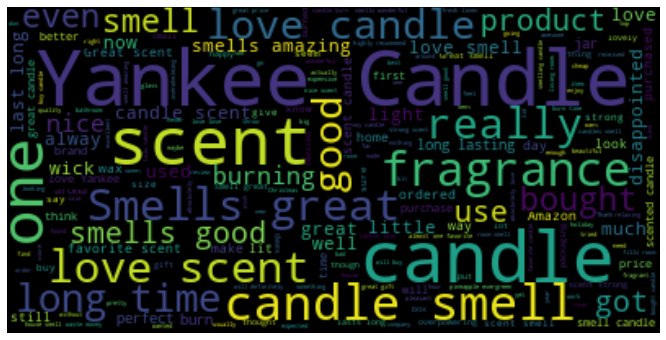

In [106]:
wordcloud_generator(candle_df)

5 star reviews


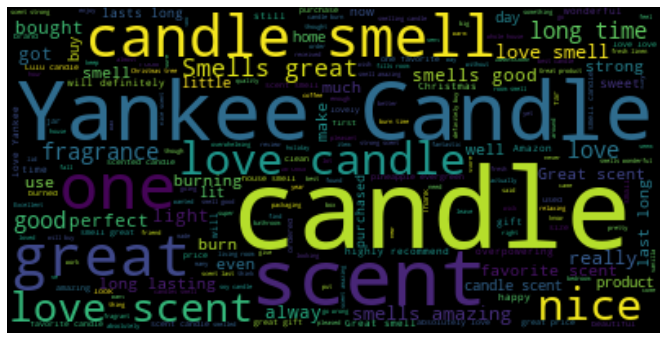

In [107]:
print('5 star reviews')
wordcloud_generator(candle_df[candle_df.rating==5])

1 star reviews


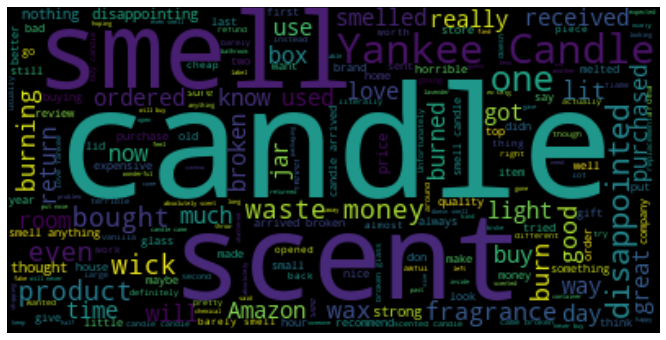

In [108]:
print('1 star reviews')
wordcloud_generator(candle_df[candle_df.rating==1])

Covid reviews


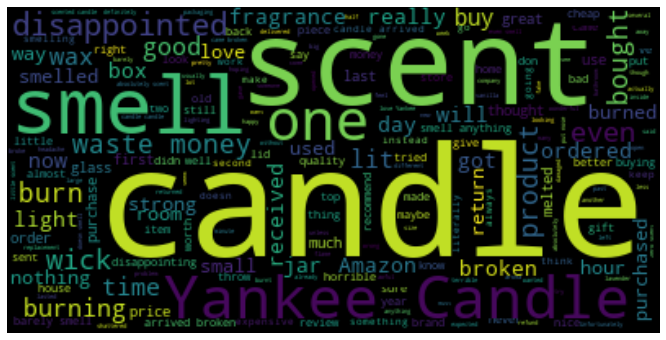

In [109]:
print('Covid reviews')
wordcloud_generator(candle_df.loc[(candle_df.rating==1)&(candle_df.date>'2020')])

In [110]:
lack = 'no smell|no scent|smells like nothing|lacks smell|lacks scent'
pre_covid = 100*candle_df.loc[(candle_df.text.str.contains(lack)) & 
                   (candle_df.date<'2020')].shape[0]/candle_df[candle_df.date<'2020'].shape[0]
post_covid = 100*candle_df.loc[(candle_df.text.str.contains(lack)) &
                    (candle_df.date>'2020')].shape[0]/candle_df[candle_df.date>'2020'].shape[0]

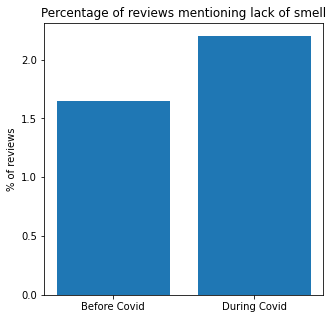

In [111]:
plt.figure(figsize=(5,5))
plt.title('Percentage of reviews mentioning lack of smell')
plt.ylabel('% of reviews')
plt.bar(['Before Covid', 'During Covid'], [pre_covid, post_covid])
plt.show()

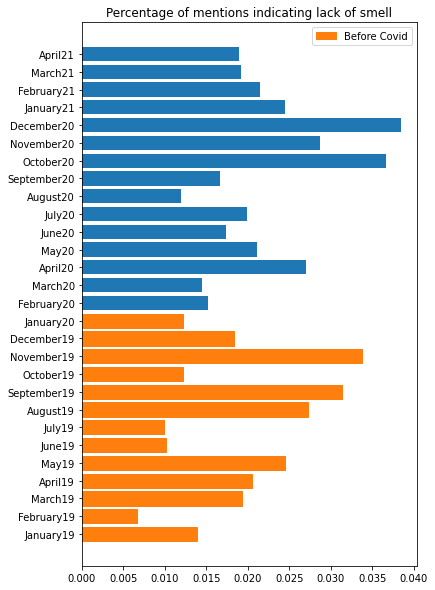

In [112]:
no_smell_df = df.loc[(df.text.str.contains(lack))&(df.date>'2020')&(df.date<'2021')]
total_aux = df.loc[(df.date>'2020')&(df.date<'2021')]
total_aux = total_aux.groupby('month')['text'].count()
aux = no_smell_df.groupby('month')['text'].count()/total_aux
aux.index = ['April20', 'August20', 'December20', 'February20', 'January20', 'July20', 'June20',
       'March20', 'May20', 'November20', 'October20', 'September20']

no_smell_df = df.loc[(df.text.str.contains(lack))&(df.date>'2021')]
total_aux = df.loc[(df.date>'2021')]
total_aux = total_aux.groupby('month')['text'].count()
aux2 = no_smell_df.groupby('month')['text'].count()/total_aux
mask = aux2.index.isin(['May'])
aux2 = aux2[~mask]
aux2.index = ['April21', 'February21', 'January21', 'March21']

no_smell_df = df.loc[(df.text.str.contains(lack))&(df.date>'2019')&(df.date<'2020')]
total_aux = df.loc[(df.date>'2019')&(df.date<'2020')]
total_aux = total_aux.groupby('month')['text'].count()
aux3 = no_smell_df.groupby('month')['text'].count()/total_aux
aux3.index = ['April19', 'August19', 'December19', 'February19', 'January19', 'July19', 'June19',
       'March19', 'May19', 'November19', 'October19', 'September19']

aux = pd.concat([aux, aux2, aux3])
months = ['January19', 'February19', 'March19', 'April19', 'May19', 'June19', 'July19',
          'August19', 'September19', 'October19', 'November19', 'December19',
          'January20', 'February20', 'March20', 'April20', 'May20', 'June20', 'July20',
          'August20', 'September20', 'October20', 'November20', 'December20', 
          'January21', 'February21', 'March21', 'April21']

plt.figure(figsize=(6, 10))
plt.title('Percentage of mentions indicating lack of smell')
barlist = plt.barh(months, aux[months])
for i in range(13):
  barlist[i].set_color('C1')
covid = mpatches.Patch(color='C1', label='Before Covid')
plt.legend(handles=[covid])
plt.show()

## Conclusion

In [113]:
USA = 331002651
max_covid = max(covid_df.active_cases)
max_purchases = max(debug.purchases)

In [114]:
def covid_bin(n, p, k):
  aux = math.factorial(n)/(math.factorial(n-k)*math.factorial(k))
  aux = aux*(p**k)*((1-p)**(n-k))
  return aux, n*p

In [115]:
a, b = covid_bin(71, max_covid/USA, 0)
print(f'The probability that 0 people with covid is {a*100:.2f}%')
print(f'The amount of people expected to have covid is {round(b)} out of {71}')

The probability that 0 people with covid is 14.04%
The amount of people expected to have covid is 2 out of 71


In [116]:
max(debug[debug.active_cases>0].purchases)

71.0

In [117]:
debug[debug.purchases==71]

,date,active_cases,active_casesXscented,rating,purchases,scented,id_CedarYankee,id_CinnamonYankee,id_CitrusYankee,id_HomeYankee,id_LilacYankee,id_PearChesapeake Bay,id_SoyLulu,id_SoyMrs.Meyers,id_VanillaYankee,id_un1,id_un10,id_un11,id_un12,id_un13,id_un14,id_un15,id_un2,id_un3,id_un4,id_un5,id_un6,id_un7,id_un8,id_un9,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,year_2006,year_2007,year_2008,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
1575,2020-01-05,0.00,0.00,1,71.00,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1576,2020-01-05,0.00,0.00,5,71.00,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1577,2020-01-05,0.00,0.00,5,71.00,1,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1578,2020-01-05,0.00,0.00,5,71.00,1,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1579,2020-01-05,0.00,0.00,5,71.00,1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7284,2021-01-11,15.95,0.00,5,71.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7285,2021-01-11,15.95,0.00,5,71.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7286,2021-01-11,15.95,0.00,5,71.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7287,2021-01-11,15.95,0.00,5,71.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [118]:
covid_df[covid_df.date=="2021-01-11"]

,date,daily_new_cases,active_cases
326,2021-01-11,216386.00,8421206.00


In [119]:
covid_df[covid_df.active_cases==9027330.0]

,date,daily_new_cases,active_cases
339,2021-01-24,143450.00,9027330.00
